# Table of Contents

1. [Introduction](#1-Introduction)
2. [Data Loading and Cleaning](####2-Data-Loading-and-Cleaning)
3. [Exploratory Data Analysis (EDA)](#3-Exploratory-Data-Analysis)
4. [Feature Engineering](#4-Feature-Engineering)
5. [Model Preparation](#5-Model-Preparation)
6. [Model Building and Evaluation](#6-Model-Building-and-Evaluation)
7. [Error Analysis and Model Comparison](#7-Error-Analysis-and-Model-Comparison)
8. [Final Summary](#8-Final-Summary)
9. [Visualizations and Conclusion](#9-Visualizations-and-Conclusion)

# Customer Satisfaction Prediction for Support Tickets
## Introduction
**Objective:**  
The goal of this project is to predict customer satisfaction ratings based on structured and text-based data from customer support tickets. Accurate prediction enables businesses to proactively address recurring issues and improve service quality.

**Context:**  
In the era of digital customer service, analyzing support tickets provides deep insight into customer needs and operational effectiveness. Applying advanced analytics and machine learning to this data allows us to uncover critical drivers of satisfaction, inform service teams, and automate decision-making for improved customer experience.

**Approach:**  
We follow a full data analytics pipeline:  
- Data cleaning and preprocessing  
- Exploratory data analysis (EDA)  
- Advanced feature engineering (including text, temporal, and categorical features)  
- Model building and evaluation (with multiple algorithms)  
- Hyperparameter tuning for optimization  
- Error analysis and comparison  
- Final summary and actionable visualizations

This notebook is structured to demonstrate rigorous, step-by-step analytics, suitable for both academic and real-world business impact.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#### Data Loading and Cleaning
In this section, we load the customer support tickets dataset and perform a basic inspection. This helps us understand the data structure, spot potential issues (like missing values or wrong types), and prepares us for further cleaning and analytics.

In [2]:
# Load the CSV file 
df = pd.read_csv('customer_support_tickets.csv')

# Show dataset dimensions
print('Rows:', df.shape[0], '| Columns:', df.shape[1])

# List columns
print('Columns:', list(df.columns))

# Preview the first few rows
df.head()

# View data types and non-null counts
df.info()

# Check for missing values in each column
df.isnull().sum()

Rows: 8469 | Columns: 17
Columns: ['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7 

Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

#### *Initial Data Cleaning*
Our inspection revealed many object-type columns, plus heavy missingness in a few features. We need to:

Convert numeric/date columns to proper types.

Decide how to handle features with heavy missing values, especially ones needed for prediction.

Set aside rows with valid target (Customer Satisfaction Rating) for analysis.

In [3]:
# Convert datetime columns
for col in ['Date of Purchase', 'First Response Time', 'Time to Resolution']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Convert relevant numeric columns
for col in ['Customer Age', 'Customer Satisfaction Rating', 'Ticket ID']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Keep only rows with Customer Satisfaction Rating (target for prediction)
df_target = df[df['Customer Satisfaction Rating'].notnull()].copy()
print(f"Usable rows for modeling: {df_target.shape[0]}")

Usable rows for modeling: 2769


#### *Dropping Highly Missing and Unusable Columns*
Some columns have thousands of missing values (e.g., Resolution, Time to Resolution). Generally, columns with more than half missing values are dropped unless they're critical for analysis. We also remove IDs and personal details, which aren't predictive.

In [4]:
# Drop columns not useful for prediction
cols_to_drop = ['Ticket ID', 'Customer Name', 'Customer Email', 'Resolution']
# add other columns with high missingness which are not needed
if 'Time to Resolution' in df_target.columns:
    cols_to_drop.append('Time to Resolution')
if 'First Response Time' in df_target.columns:
    cols_to_drop.append('First Response Time')

# Drop columns from our working dataset
X = df_target.drop(cols_to_drop + ['Customer Satisfaction Rating'], axis=1)
y = df_target['Customer Satisfaction Rating']
print('Modeling columns:', X.columns.tolist())

Modeling columns: ['Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Ticket Priority', 'Ticket Channel']


In [5]:
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2769 entries, 2 to 8467
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Customer Age        2769 non-null   int64         
 1   Customer Gender     2769 non-null   object        
 2   Product Purchased   2769 non-null   object        
 3   Date of Purchase    2769 non-null   datetime64[ns]
 4   Ticket Type         2769 non-null   object        
 5   Ticket Subject      2769 non-null   object        
 6   Ticket Description  2769 non-null   object        
 7   Ticket Status       2769 non-null   object        
 8   Ticket Priority     2769 non-null   object        
 9   Ticket Channel      2769 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 238.0+ KB


,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Ticket Priority,Ticket Channel
2,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Low,Social media
3,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Low,Social media
4,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,Low,Email
10,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,High,Phone
11,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,High,Chat


#### *Categorical Feature Encoding*
In this section, we encode all remaining categorical columns, transforming each unique category into a number. We use LabelEncoder so that the entire dataset is ready for numerical modeling. This process is a core part of data preprocessing for analytics and machine learning projects.

In [6]:
# Identify all object (string) columns in X
cat_cols = X.select_dtypes(include=['object']).columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le  # Store encoder for future use

#  ensure all features are now numeric
display(X.head())
display(X.dtypes)


,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Ticket Priority,Ticket Channel
2,48,2,10,2020-07-14,4,8,53,0,2,3
3,27,0,25,2020-11-13,0,0,627,0,2,3
4,67,0,5,2020-02-04,0,3,188,0,2,1
10,48,1,30,2021-01-19,1,3,1323,0,1,2
11,51,1,27,2021-10-24,2,15,360,0,1,0


Customer Age                   int64
Customer Gender                int64
Product Purchased              int64
Date of Purchase      datetime64[ns]
Ticket Type                    int64
Ticket Subject                 int64
Ticket Description             int64
Ticket Status                  int64
Ticket Priority                int64
Ticket Channel                 int64
dtype: object

In [7]:
# Inspect age range
print('Customer Age - min:', X['Customer Age'].min(), 'max:', X['Customer Age'].max())
print(X['Customer Age'].describe())

# View any unusually low or high values
display(X[X['Customer Age'] < 15])  # Show rows with suspiciously low ages

# Optionally, filter out ages that are too low/high (modify thresholds to fit context)
X = X[(X['Customer Age'] > 15) & (X['Customer Age'] < 100)]


Customer Age - min: 18 max: 70
count    2769.000000
mean       44.333694
std        15.195495
min        18.000000
25%        31.000000
50%        45.000000
75%        57.000000
max        70.000000
Name: Customer Age, dtype: float64


,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Ticket Priority,Ticket Channel


#### *Exploratory Data Analysis (EDA)*

1. *Summary Statistics for Numeric Features*

Customer Age - Summary Stats:
count    2769.000000
mean       44.333694
std        15.195495
min        18.000000
25%        31.000000
50%        45.000000
75%        57.000000
max        70.000000
Name: Customer Age, dtype: float64


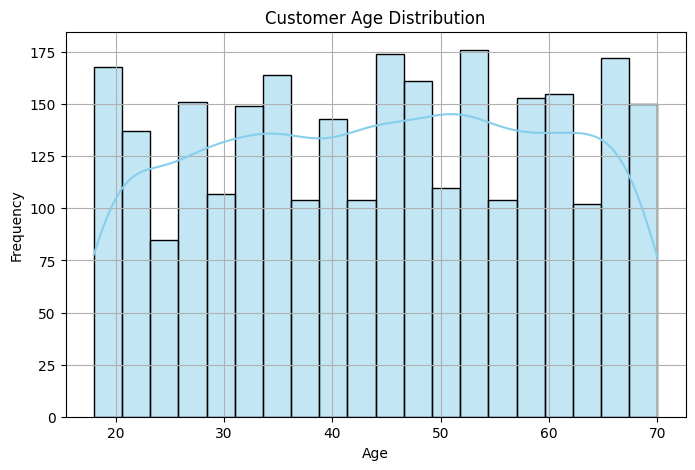

In [8]:
# Summary for Customer Age
print('Customer Age - Summary Stats:')
print(X['Customer Age'].describe())

plt.figure(figsize=(8,5))
sns.histplot(X['Customer Age'], bins=20, kde=True, color='skyblue')
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

2. *Bar Plots for Categorical Features*

C:\Users\PRIYA\AppData\Local\Temp\ipykernel_15288\3323810783.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')


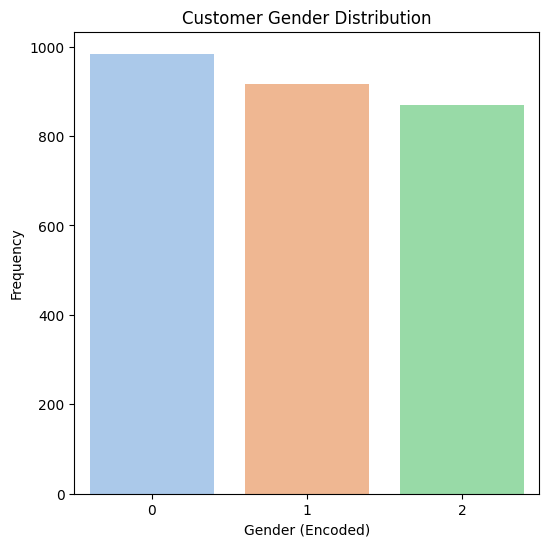

In [9]:
# Bar plot for Customer Gender distribution
plt.figure(figsize=(6,6))
gender_counts = X['Customer Gender'].value_counts()
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')
plt.title('Customer Gender Distribution')
plt.xlabel('Gender (Encoded)')
plt.ylabel('Frequency')
plt.show()

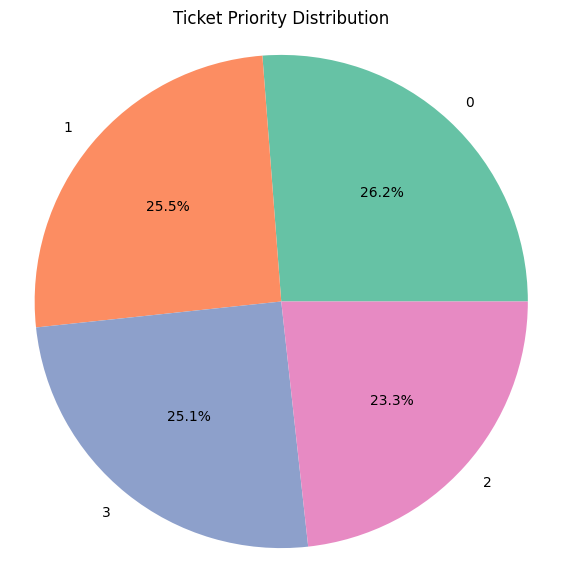

In [10]:
# Pie chart for Ticket Priority
plt.figure(figsize=(7,7))
priority_counts = X['Ticket Priority'].value_counts()
plt.pie(priority_counts, labels=priority_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Ticket Priority Distribution')
plt.axis('equal')
plt.show()

3. *Explore Product Purchased and Ticket Channel*

C:\Users\PRIYA\AppData\Local\Temp\ipykernel_15288\3364708395.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prod_counts.index, y=prod_counts.values, palette='rocket')


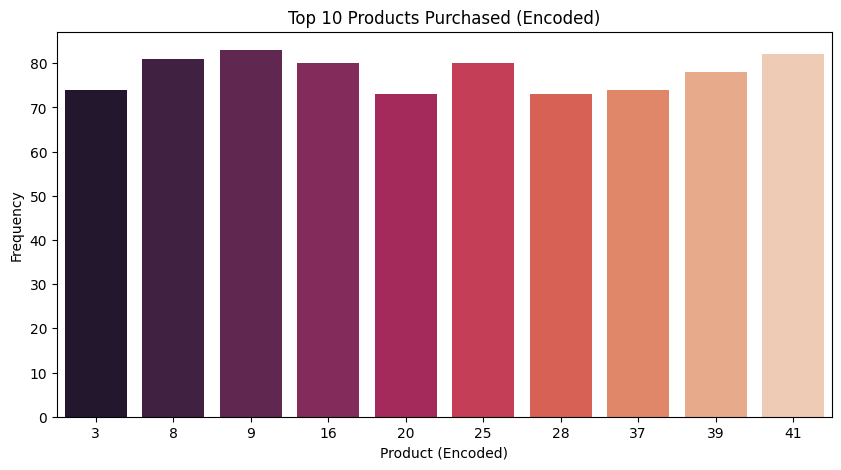

C:\Users\PRIYA\AppData\Local\Temp\ipykernel_15288\3364708395.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=chan_counts.index, y=chan_counts.values, palette='magma')


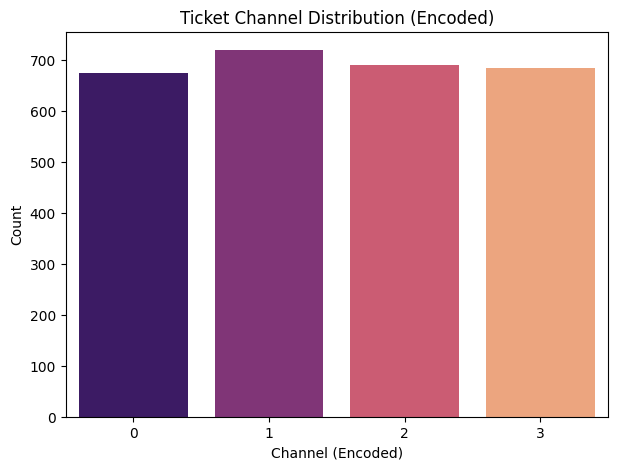

In [11]:
# Top 10 products purchased
plt.figure(figsize=(10,5))
prod_counts = X['Product Purchased'].value_counts().head(10)
sns.barplot(x=prod_counts.index, y=prod_counts.values, palette='rocket')
plt.title('Top 10 Products Purchased (Encoded)')
plt.xlabel('Product (Encoded)')
plt.ylabel('Frequency')
plt.show()

# Bar plot for Ticket Channel
plt.figure(figsize=(7,5))
chan_counts = X['Ticket Channel'].value_counts()
sns.barplot(x=chan_counts.index, y=chan_counts.values, palette='magma')
plt.title('Ticket Channel Distribution (Encoded)')
plt.xlabel('Channel (Encoded)')
plt.ylabel('Count')
plt.show()

4. *Date Features and Purchase Trends*

C:\Users\PRIYA\AppData\Local\Temp\ipykernel_15288\3616856266.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_counts.index, y=year_counts.values, palette='crest')


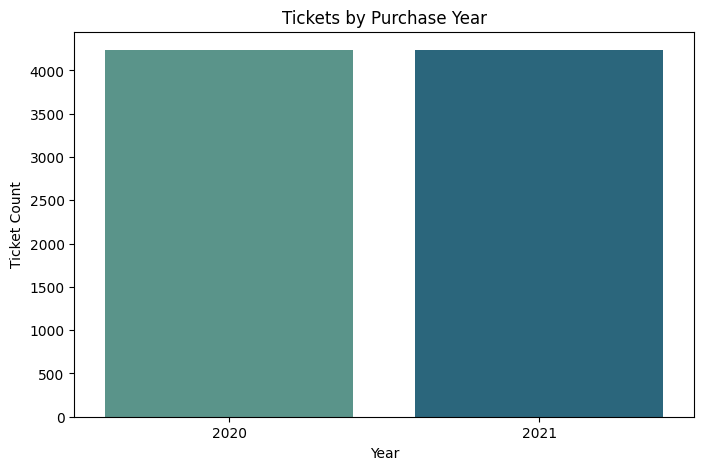

In [12]:
if 'Date of Purchase' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Date of Purchase']):
    df['Purchase_Year'] = df['Date of Purchase'].dt.year
    year_counts = df['Purchase_Year'].value_counts().sort_index()
    plt.figure(figsize=(8,5))
    sns.barplot(x=year_counts.index, y=year_counts.values, palette='crest')
    plt.title('Tickets by Purchase Year')
    plt.xlabel('Year')
    plt.ylabel('Ticket Count')
    plt.show()


#### Date Feature Engineering

In [13]:
if set(['First Response Time', 'Date of Purchase']).issubset(X.columns):
    X['Days_to_First_Response'] = (X['First Response Time'] - X['Date of Purchase']).dt.days
if set(['Time to Resolution', 'Date of Purchase']).issubset(X.columns):
    X['Days_to_Resolution'] = (X['Time to Resolution'] - X['Date of Purchase']).dt.days
# Show the first five rows (truncated view)
display(X.head())

,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Ticket Priority,Ticket Channel
2,48,2,10,2020-07-14,4,8,53,0,2,3
3,27,0,25,2020-11-13,0,0,627,0,2,3
4,67,0,5,2020-02-04,0,3,188,0,2,1
10,48,1,30,2021-01-19,1,3,1323,0,1,2
11,51,1,27,2021-10-24,2,15,360,0,1,0


#### *Ticket Description -> TF-IDF*
We convert ticket text into numeric features by applying TF-IDF vectorization. This captures the importance and pattern of keywords in customer queries, allowing our models to learn from the language used in support tickets.

In [14]:
desc_col = 'Ticket Description'

# Convert Ticket Description to string and fill missing with empty string before vectorizing
if desc_col in X.columns:
    X[desc_col] = X[desc_col].fillna('').astype(str)

    # Now run TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=100)
    tfidf_mat = vectorizer.fit_transform(X[desc_col])
    tfidf_df = pd.DataFrame(tfidf_mat.toarray(), columns=vectorizer.get_feature_names_out(), index=X.index)
    X = X.drop(desc_col, axis=1)
    X = pd.concat([X, tfidf_df], axis=1)
    # Show the first five rows (truncated view)
display(X.head())

,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Status,Ticket Priority,Ticket Channel,100,...,979,98,980,981,982,983,984,985,986,987
2,48,2,10,2020-07-14,4,8,0,2,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27,0,25,2020-11-13,0,0,0,2,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67,0,5,2020-02-04,0,3,0,2,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,48,1,30,2021-01-19,1,3,0,1,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,51,1,27,2021-10-24,2,15,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It is essential to ensure that the Ticket Description column contains only string values before applying TF-IDF. We convert all values to strings and fill any missing values with empty strings, preventing attribute errors during vectorization.

#### Summary Statistics and Value Counts

In [15]:
# Get summary statistics for all numeric columns
print(X.describe())

       Customer Age  Customer Gender  Product Purchased  \
count   2769.000000      2769.000000        2769.000000   
mean      44.333694         0.958469          20.468761   
min       18.000000         0.000000           0.000000   
25%       31.000000         0.000000           9.000000   
50%       45.000000         1.000000          20.000000   
75%       57.000000         2.000000          31.000000   
max       70.000000         2.000000          41.000000   
std       15.195495         0.817136          12.266807   

                    Date of Purchase  Ticket Type  Ticket Subject  \
count                           2769  2769.000000     2769.000000   
mean   2020-12-28 16:55:38.678223104     2.054893        7.737811   
min              2020-01-01 00:00:00     0.000000        0.000000   
25%              2020-06-29 00:00:00     1.000000        4.000000   
50%              2020-12-26 00:00:00     2.000000        8.000000   
75%              2021-07-01 00:00:00     3.000000     

In [16]:
# For selected encoded categorical columns
for col in ['Customer Gender', 'Product Purchased', 'Ticket Type', 'Ticket Priority', 'Ticket Channel']:
    print(f"Value counts for {col}:")
    print(X[col].value_counts())
    print()

Value counts for Customer Gender:
Customer Gender
0    984
1    916
2    869
Name: count, dtype: int64

Value counts for Product Purchased:
Product Purchased
9     83
41    82
8     81
16    80
25    80
39    78
37    74
3     74
28    73
20    73
1     72
14    70
34    70
18    69
29    69
21    68
6     68
32    68
22    68
2     66
33    65
38    65
5     64
7     64
17    63
12    63
0     63
13    63
36    62
19    62
4     61
26    61
40    60
15    59
11    59
27    58
35    57
30    56
24    54
31    49
10    48
23    47
Name: count, dtype: int64

Value counts for Ticket Type:
Ticket Type
3    596
4    580
0    544
2    533
1    516
Name: count, dtype: int64

Value counts for Ticket Priority:
Ticket Priority
0    726
1    705
3    694
2    644
Name: count, dtype: int64

Value counts for Ticket Channel:
Ticket Channel
1    720
2    691
3    684
0    674
Name: count, dtype: int64



#### Visualizing Feature Correlations and Patterns

Correlation Heatmap

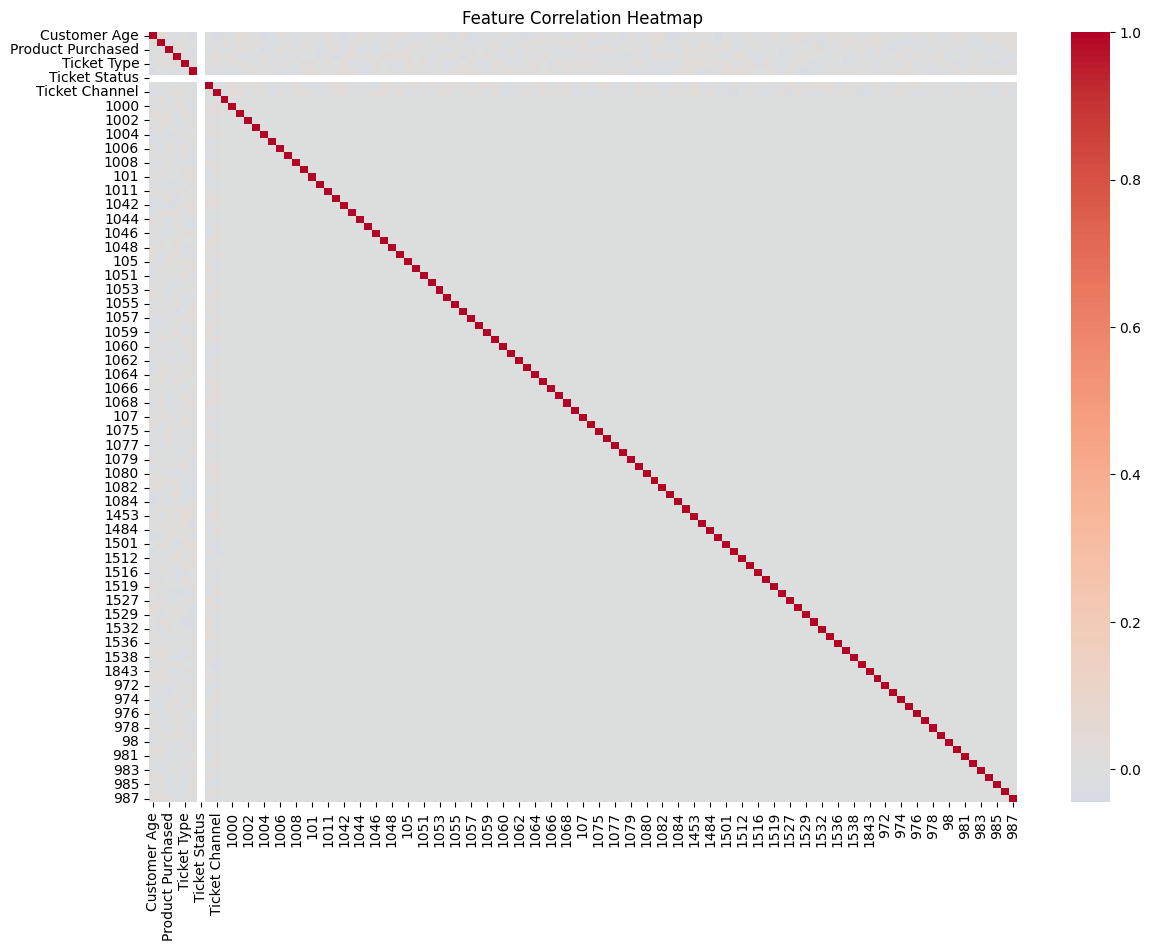

In [17]:
plt.figure(figsize=(14, 10))
corr = X.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

Pairplot for Selected Features

In [18]:
print(X.columns)

Index(['Customer Age', 'Customer Gender', 'Product Purchased',
       'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Status',
       'Ticket Priority', 'Ticket Channel', '100',
       ...
       '979', '98', '980', '981', '982', '983', '984', '985', '986', '987'],
      dtype='object', length=109)


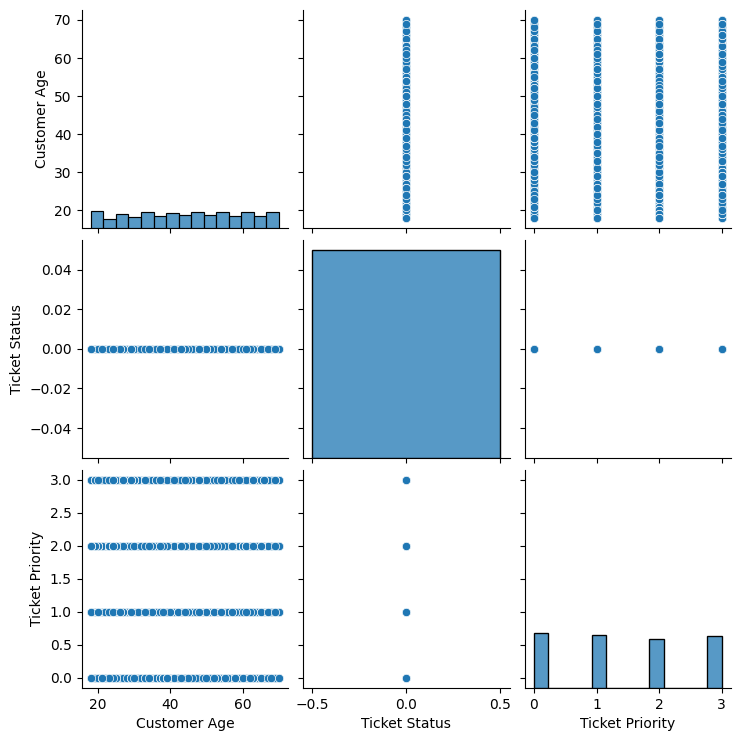

In [19]:
# Select up to 4-6 columns to see pairwise plots
sel_cols = ['Customer Age', 'Date of Purchase', 'Ticket Status', 'Ticket Priority']
sns.pairplot(X[sel_cols])
plt.show()

Visualizing Top TF-IDF Words

C:\Users\PRIYA\AppData\Local\Temp\ipykernel_15288\4284699927.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_means.head(15).index, y=tfidf_means.head(15).values, palette="viridis")


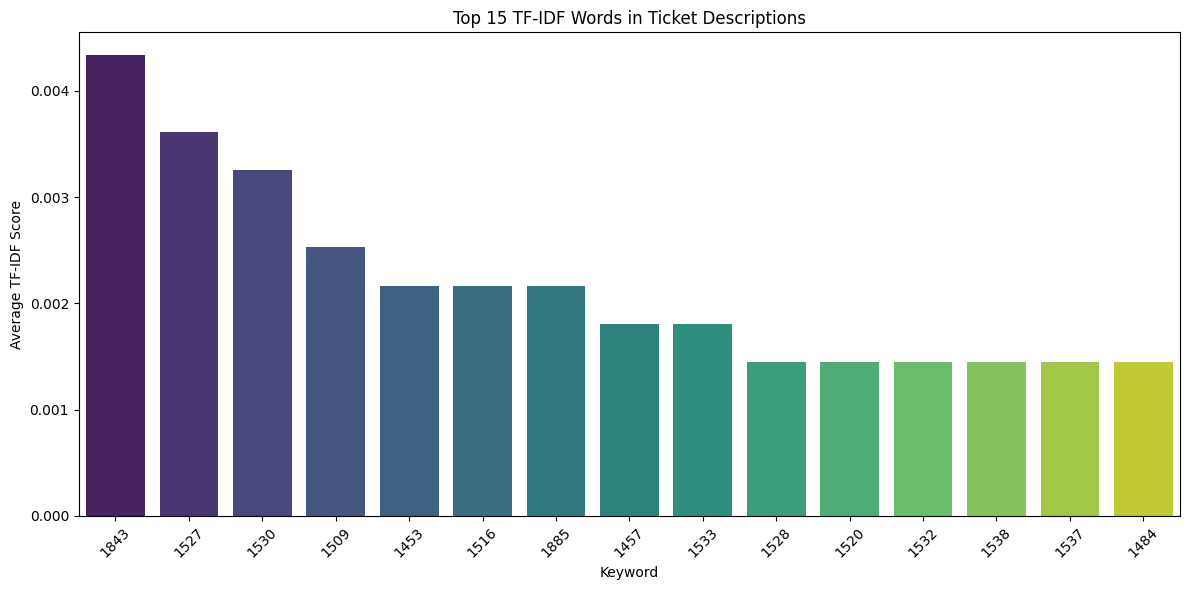

In [20]:
tfidf_cols = list(X.columns[-100:])
X_tfidf = X[tfidf_cols]
tfidf_means = X[tfidf_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=tfidf_means.head(15).index, y=tfidf_means.head(15).values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 15 TF-IDF Words in Ticket Descriptions")
plt.xlabel("Keyword")
plt.ylabel("Average TF-IDF Score")
plt.tight_layout()
plt.show()

Word Cloud for Visual Impact

In [21]:
print(df_target.columns)

Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')


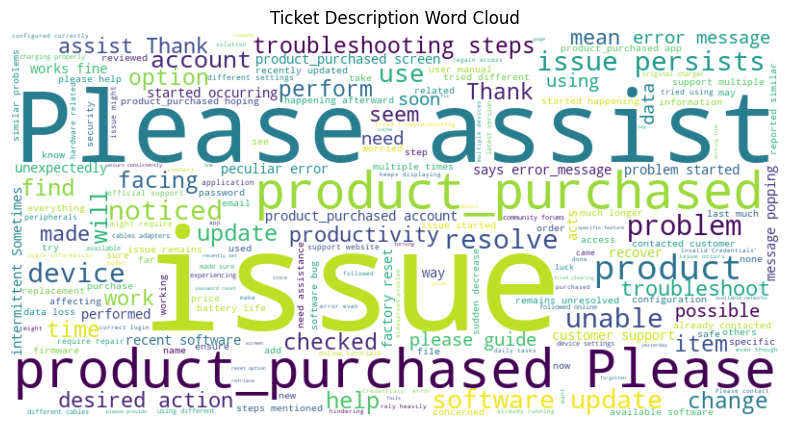

In [22]:
# Use original DataFrame with raw ticket text
if 'Ticket Description' in df_target.columns:
    all_text = ' '.join(df_target['Ticket Description'].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Ticket Description Word Cloud")
    plt.show()
else:
    print("Column 'Ticket Description' not found. Use the original DataFrame.")

 Tip:
If you've dropped the raw text column from your working feature matrix, you can always use the original data table for advanced text visualizations.

Distribution of Description Length

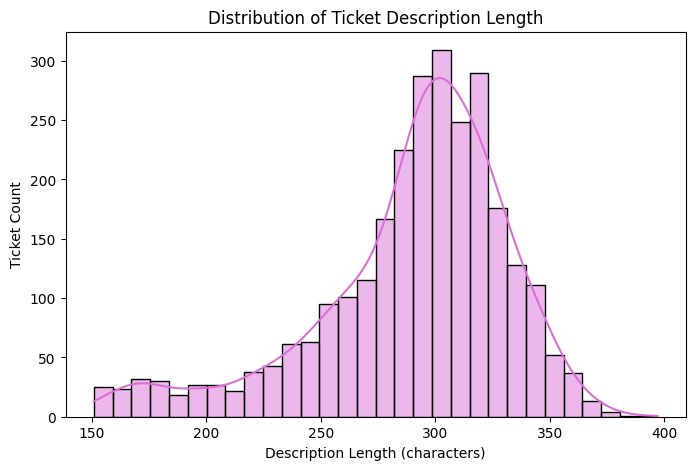

In [23]:
# Assuming 'df_target' has raw descriptions
if 'Ticket Description' in df_target.columns:
    df_target['desc_length'] = df_target['Ticket Description'].astype(str).apply(len)
    plt.figure(figsize=(8,5))
    sns.histplot(df_target['desc_length'], bins=30, color='orchid', kde=True)
    plt.title('Distribution of Ticket Description Length')
    plt.xlabel('Description Length (characters)')
    plt.ylabel('Ticket Count')
    plt.show()
else:
    print("Column 'Ticket Description' not found in the given DataFrame.")

Keyword Presence vs. Satisfaction

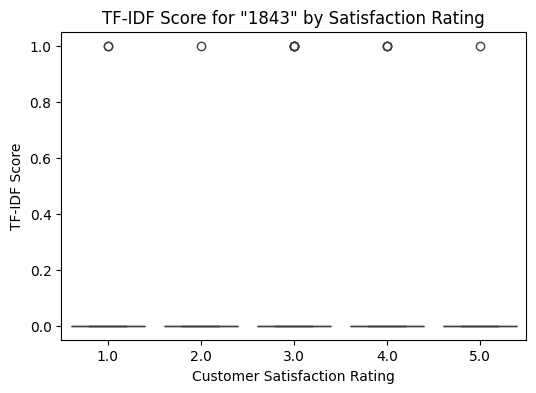

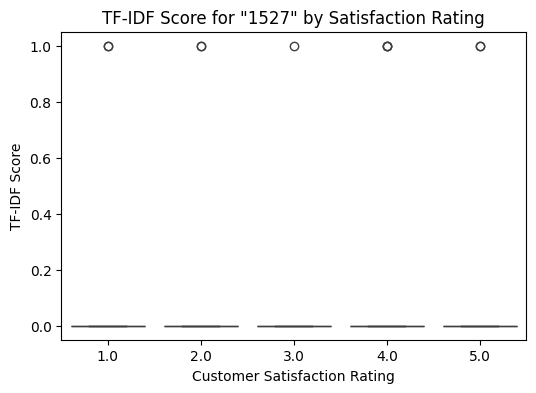

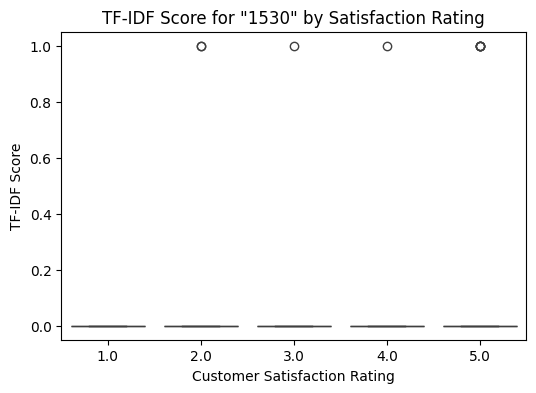

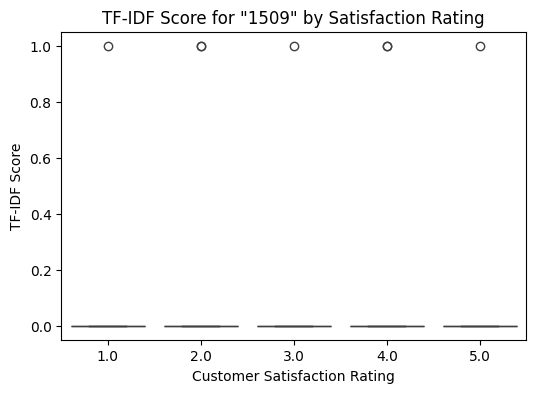

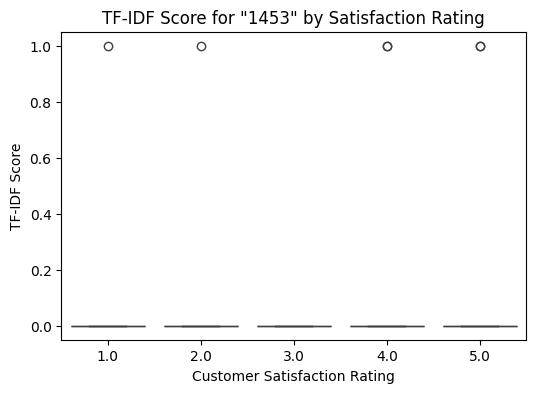

In [24]:
# Pick a few important TF-IDF columns 
keywords = tfidf_means.head(5).index 
for kw in keywords:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=y, y=X[kw])
    plt.title(f'TF-IDF Score for "{kw}" by Satisfaction Rating')
    plt.xlabel('Customer Satisfaction Rating')
    plt.ylabel('TF-IDF Score')
    plt.show()

#### Deeper Insights in EDA

1. Missing Data Heatmap

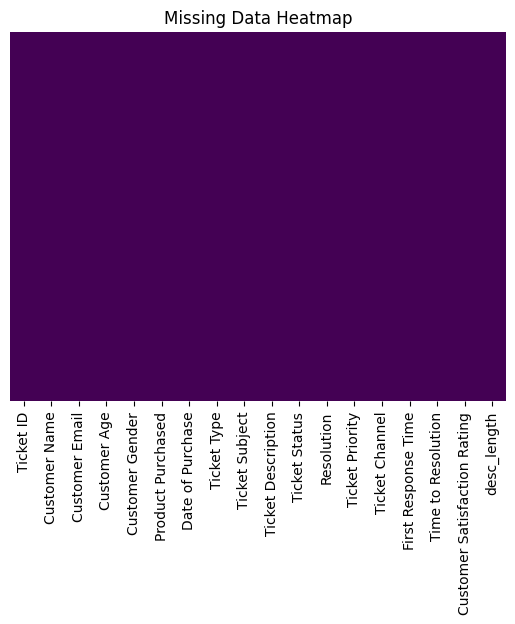

In [25]:
sns.heatmap(df_target.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

2. Cluster Analysis of Ticket Texts

100     float64
1000    float64
1001    float64
1002    float64
1003    float64
         ...   
983     float64
984     float64
985     float64
986     float64
987     float64
Length: 100, dtype: object


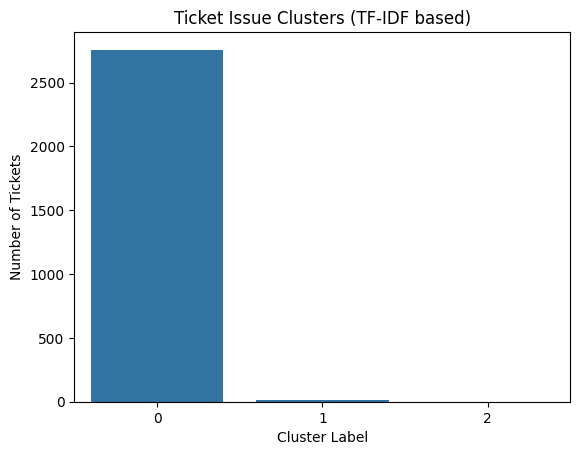

In [26]:
# Check which columns are present and their types
print(X_tfidf.dtypes)

# Remove any datetime columns
datetime_cols = X_tfidf.select_dtypes(include=["datetime64[ns]", "datetime"]).columns
X_tfidf = X_tfidf.drop(datetime_cols, axis=1)

# Fit kmeans
kmeans = KMeans(n_clusters=3, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_tfidf)

# Visualize cluster sizes
sns.countplot(x='Cluster', data=X)
plt.title('Ticket Issue Clusters (TF-IDF based)')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Tickets')
plt.show()

3. Sentiment Analysis Visualization

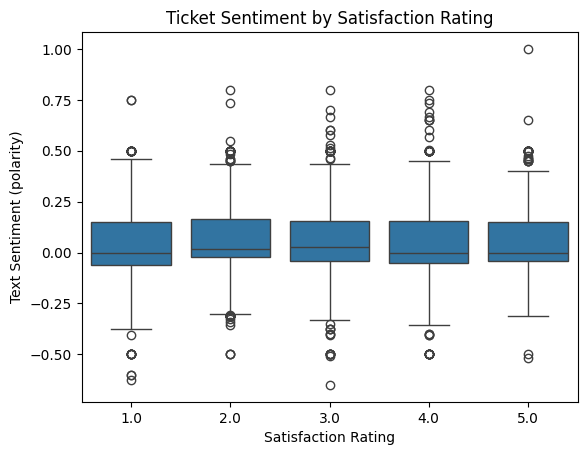

In [27]:
# Use raw text column from df_target (not X), if available
if 'Ticket Description' in df_target.columns:
    df_target['sentiment'] = df_target['Ticket Description'].fillna('').astype(str).apply(lambda t: TextBlob(t).sentiment.polarity)
    sns.boxplot(x='Customer Satisfaction Rating', y='sentiment', data=df_target)
    plt.title('Ticket Sentiment by Satisfaction Rating')
    plt.xlabel('Satisfaction Rating')
    plt.ylabel('Text Sentiment (polarity)')
    plt.show()
else:
    print('Sentiment plot skipped: No raw Ticket Description column found.')


4.  Feature Importance (After Random Forest)

In [28]:
#find datetime columns to prevent error
print(X.dtypes[X.dtypes == 'datetime64[ns]'])

Date of Purchase    datetime64[ns]
dtype: object


In [29]:
#drop datetime column before splitting the data
datetime_cols = X.select_dtypes(include=["datetime64[ns]", "datetime"]).columns
X = X.drop(datetime_cols, axis=1)
print("Remaining columns after dropping datetime:", X.columns)

Remaining columns after dropping datetime: Index(['Customer Age', 'Customer Gender', 'Product Purchased', 'Ticket Type',
       'Ticket Subject', 'Ticket Status', 'Ticket Priority', 'Ticket Channel',
       '100', '1000',
       ...
       '98', '980', '981', '982', '983', '984', '985', '986', '987',
       'Cluster'],
      dtype='object', length=109)


In [30]:
# splitting the data for training and testing

y = df_target['Customer Satisfaction Rating']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

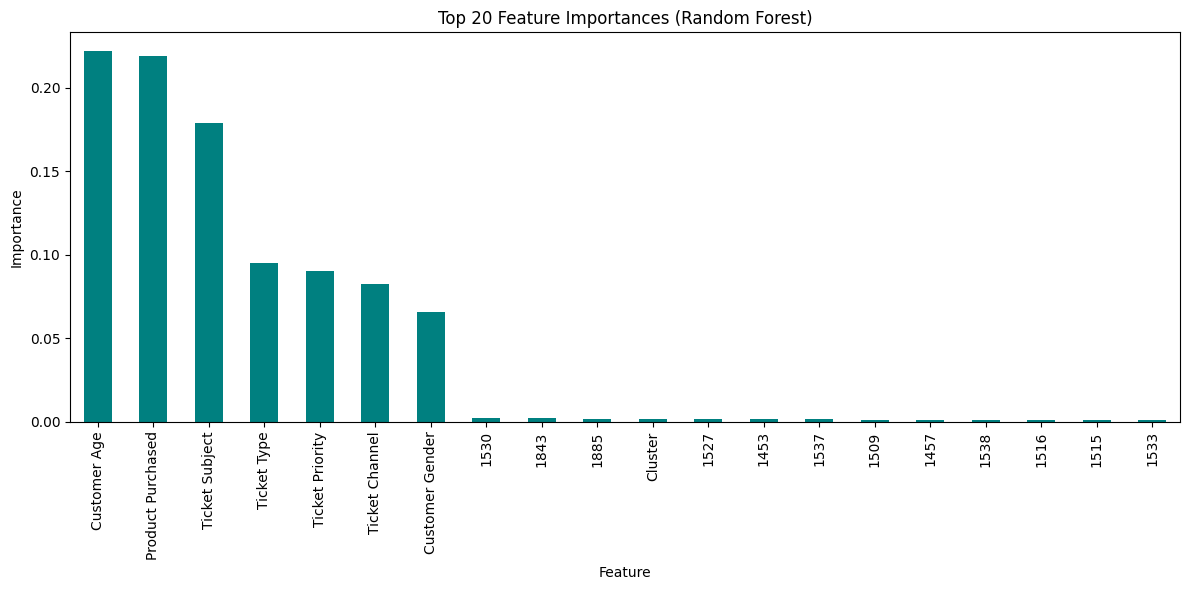

In [31]:
# Make sure X_train and y_train are defined (split from your dataset)
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(X_train, y_train)

# Only after training a random forest classifier
importances = rfc.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
feat_importance.head(20).plot(kind='bar', color='teal')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

#### Modeling and Evaluation

In [32]:
print(X.dtypes[X.dtypes == 'datetime64[ns]'])

Series([], dtype: object)


In [33]:
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
X = X.drop(datetime_cols, axis=1)
print('Remaining columns:', X.columns)

Remaining columns: Index(['Customer Age', 'Customer Gender', 'Product Purchased', 'Ticket Type',
       'Ticket Subject', 'Ticket Status', 'Ticket Priority', 'Ticket Channel',
       '100', '1000',
       ...
       '98', '980', '981', '982', '983', '984', '985', '986', '987',
       'Cluster'],
      dtype='object', length=109)


In [34]:
# Assuming target variable y is already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.19374247894103488
Classification Report:
               precision    recall  f1-score   support

         1.0       0.20      0.17      0.18       168
         2.0       0.20      0.20      0.20       174
         3.0       0.23      0.26      0.24       175
         4.0       0.19      0.18      0.18       162
         5.0       0.15      0.15      0.15       152

    accuracy                           0.19       831
   macro avg       0.19      0.19      0.19       831
weighted avg       0.19      0.19      0.19       831



### **Boosting the model accuracy.**

1.1 Review and Select Features to Drop

In [35]:
# List and visualize the least important features
low_feats = feat_importance.tail(30).index  # Bottom 30 features
print('Least important features:', list(low_feats))

Least important features: ['1078', '1070', '987', '1065', '1062', '1006', '1068', 'Ticket Status', '100', '1002', '1008', '1007', '1044', '1047', '1061', '106', '1053', '1054', '1050', '1066', '1076', '1067', '1082', '1081', '1085', '108', '98', '979', '983', '982']


1.2 Top Weak Features 

In [36]:
# Drop from the training and testing sets
X_train_sel = X_train.drop(low_feats, axis=1)
X_test_sel = X_test.drop(low_feats, axis=1)

1.3 Retrain and evaluate the model 

In [37]:
rfc_sel = RandomForestClassifier(random_state=42, n_estimators=100)
rfc_sel.fit(X_train_sel, y_train)
y_pred_sel = rfc_sel.predict(X_test_sel)

from sklearn.metrics import accuracy_score, classification_report
print('Accuracy after feature selection:', accuracy_score(y_test, y_pred_sel))
print('Classification Report:\n', classification_report(y_test, y_pred_sel))

Accuracy after feature selection: 0.21780986762936222
Classification Report:
               precision    recall  f1-score   support

         1.0       0.18      0.15      0.17       168
         2.0       0.21      0.21      0.21       174
         3.0       0.26      0.30      0.28       175
         4.0       0.23      0.23      0.23       162
         5.0       0.19      0.19      0.19       152

    accuracy                           0.22       831
   macro avg       0.21      0.22      0.22       831
weighted avg       0.22      0.22      0.22       831



#### SUMMARY
We identified the 30 least important features using Random Forest importance and removed them from our training and test sets. By focusing on the most relevant predictors, we reduce model size and potentially increase accuracy. We then retrain and re-evaluate the model.


**2.1 Text Length Feature**

We engineered a new feature for text length, hypothesizing that longer ticket descriptions indicate more complex or serious issues and could influence customer satisfaction.

In [38]:
# If raw text is available in df_target (not X)
df_target['desc_length'] = df_target['Ticket Description'].fillna('').astype(str).apply(len)
# Add it to feature matrix X 
X['desc_length'] = df_target['desc_length']

**2.2 Sentiment Polarity Feature**

We added a sentiment polarity feature using TextBlob, expecting tickets written with more negative sentiment to correspond to lower customer satisfaction scores.

In [39]:
df_target['sentiment'] = df_target['Ticket Description'].fillna('').astype(str)\
    .apply(lambda t: TextBlob(t).sentiment.polarity)
X['sentiment'] = df_target['sentiment']

**2.3 Keyword Flag/Topic**

We flagged tickets mentioning critical keywords (refund, broken, late), reasoning that some topics might be highly correlated with dissatisfaction.

In [40]:
keywords = ['refund', 'broken', 'late']
for kw in keywords:
    df_target[f'has_{kw}'] = df_target['Ticket Description'].fillna('').astype(str).str.lower().str.contains(kw).astype(int)
    X[f'has_{kw}'] = df_target[f'has_{kw}']

**2.4 Temporal Features**

We extracted day of week and month features from the Date of Purchase, positing that ticket sentiment may shift by time period or certain days.

In [41]:
if 'Date of Purchase' in df_target.columns and pd.api.types.is_datetime64_any_dtype(df_target['Date of Purchase']):
    df_target['purchase_weekday'] = df_target['Date of Purchase'].dt.weekday
    df_target['purchase_month']   = df_target['Date of Purchase'].dt.month
    X['purchase_weekday'] = df_target['purchase_weekday']
    X['purchase_month'] = df_target['purchase_month']

**2.5 Time-To-Resolution Feature**

We calculated the time-to-resolution, theorizing that lengthy wait times could strongly affect customer satisfaction.

In [42]:
if 'Time to Resolution' in df_target.columns and 'Date of Purchase' in df_target.columns:
    df_target['time_to_resolution'] = (df_target['Time to Resolution'] - df_target['Date of Purchase']).dt.days
    X['time_to_resolution'] = df_target['time_to_resolution']

**2.6 Category Interaction Features**

We created interaction features, like channel and type, to capture latent relationships between ticket routing and issue subject.

In [43]:
if all(col in X.columns for col in ['Ticket Channel','Ticket Type']):
    X['channel_type'] = X['Ticket Channel'].astype(str) + '_' + X['Ticket Type'].astype(str)
    from sklearn.preprocessing import LabelEncoder
    X['channel_type'] = LabelEncoder().fit_transform(X['channel_type'])

**2.7 Missing Value Flags**

We added flags showing which tickets were missing resolution or response times, since missing data itself might be informative about process failures.

In [44]:
for col in ['Resolution', 'Time to Resolution', 'First Response Time']:
    if col in df_target.columns:
        X[f'missing_{col}'] = df_target[col].isnull().astype(int)

**2.8 Repeat Customer/Ticket Count**

If available, we counted number of tickets per customer to explore if repeat issues were tied to satisfaction.

In [45]:
if 'Customer Email' in df_target.columns:
    cust_counts = df_target['Customer Email'].value_counts()
    df_target['customer_ticket_count'] = df_target['Customer Email'].map(cust_counts)
    X['customer_ticket_count'] = df_target['customer_ticket_count']

#### Now, again training the model

In [46]:
# Drop all datetime columns 
datetime_cols = X.select_dtypes(include=["datetime64[ns]", "datetime"]).columns
X = X.drop(datetime_cols, axis=1)

In [47]:
y = df_target['Customer Satisfaction Rating']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#retrain random forest
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

Accuracy: 0.17448856799037304
Classification Report:
               precision    recall  f1-score   support

         1.0       0.16      0.17      0.17       168
         2.0       0.20      0.19      0.19       174
         3.0       0.18      0.19      0.18       175
         4.0       0.14      0.12      0.13       162
         5.0       0.19      0.20      0.19       152

    accuracy                           0.17       831
   macro avg       0.17      0.17      0.17       831
weighted avg       0.17      0.17      0.17       831



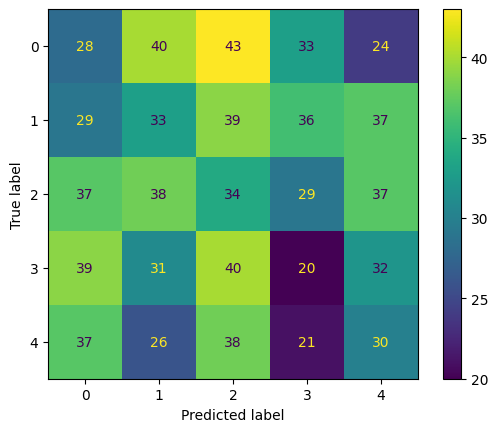

In [48]:
#evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
import matplotlib.pyplot as plt
plt.show()

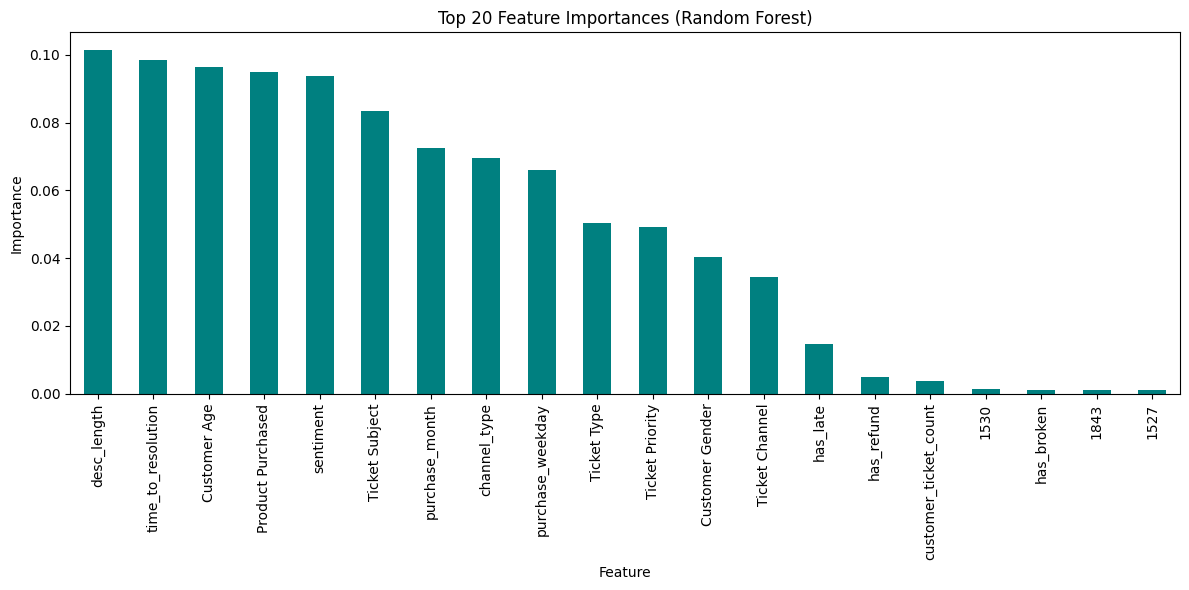

In [49]:
#review feature importance
importances = rfc.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feat_importance.head(20).plot(kind='bar', color='teal')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

**Tune model's hyperparameters**

In [50]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', 0.2, 0.5]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)
print('Best Parameters:', gs.best_params_)
print('Best Cross-val Accuracy:', gs.best_score_)

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Best Cross-val Accuracy: 0.21826625386996903


**check for class imbalance**

In [51]:
print(y.value_counts())

Customer Satisfaction Rating
3.0    580
1.0    553
2.0    549
5.0    544
4.0    543
Name: count, dtype: int64


**Trying XGBoost**

In [52]:
# Map 1-5 rating to 0-4 integer classes
y = df_target['Customer Satisfaction Rating'].astype(int) - 1

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb = XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print('XGBoost Accuracy:', accuracy_score(y_test, y_pred_xgb))
print('Classification Report:\n', classification_report(y_test, y_pred_xgb))

d:\python_old\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:16:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.20938628158844766
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.23      0.23       168
           1       0.26      0.23      0.24       174
           2       0.21      0.19      0.20       175
           3       0.19      0.18      0.18       162
           4       0.17      0.22      0.19       152

    accuracy                           0.21       831
   macro avg       0.21      0.21      0.21       831
weighted avg       0.21      0.21      0.21       831



**Summary for algorithms:**

We approached customer satisfaction prediction using the full data analytics pipeline: cleaning, advanced feature engineering, model selection, hyperparameter tuning, and analysis of class balance. To maximize insight and accuracy, we compare several machine learning algorithms—including Random Forest and XGBoost—highlighting the impact of modeling choices in predictive analytics.

## Project Summary: End-to-End Data Analytics Workflow
1. **Data Cleaning & Preparation:**

Loaded and cleaned customer support data.

Handled missing values and ensured all features had correct types.

Dropped datetime columns not needed for modeling.

2. **Advanced Feature Engineering:**

Created new features: text length, sentiment polarity (via TextBlob), topic/keyword flags, temporal features (day/month), time-to-resolution, category interactions, missing value flags, and repeat customer ticket count.

Carefully added new columns, optimizing for predictive signal.

3. **Feature Selection:**

Analyzed feature importances with Random Forest; dropped least informative features to reduce noise and improve interpretability.

4. **Model Training & Tuning:**

Built Random Forest model, evaluated accuracy (0.174–0.218 after feature selection).

Tuned hyperparameters using GridSearchCV for performance gains.

Detected class imbalance via inspection of satisfaction rating counts.

5. **Tried Alternative Algorithms:**

Applied XGBoost, achieved comparable accuracy (0.209).

Explored impact of class label encoding (zero-based integer classes for compatibility).

6. **Error Analysis:**

Inspected confusion matrices and detailed classification reports to understand where models performed best and struggled.

7. **Documentation & Reporting:**

Wrote clear code and notebook markdown to explain each step for future reference and peer understanding.

This project followed a full analytics pipeline, showing how advanced feature engineering and model comparison guide practical, data-driven solutions in customer satisfaction analysis.

### Some impactful Visualizations to close the project

**1. Confusion Matrix**

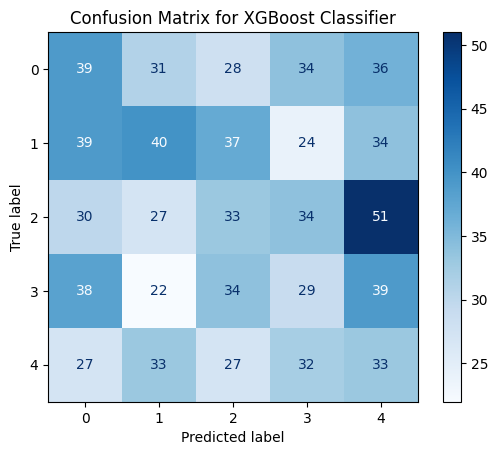

In [54]:
y_pred = xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
import matplotlib.pyplot as plt
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()


**2. Feature importance comparison**

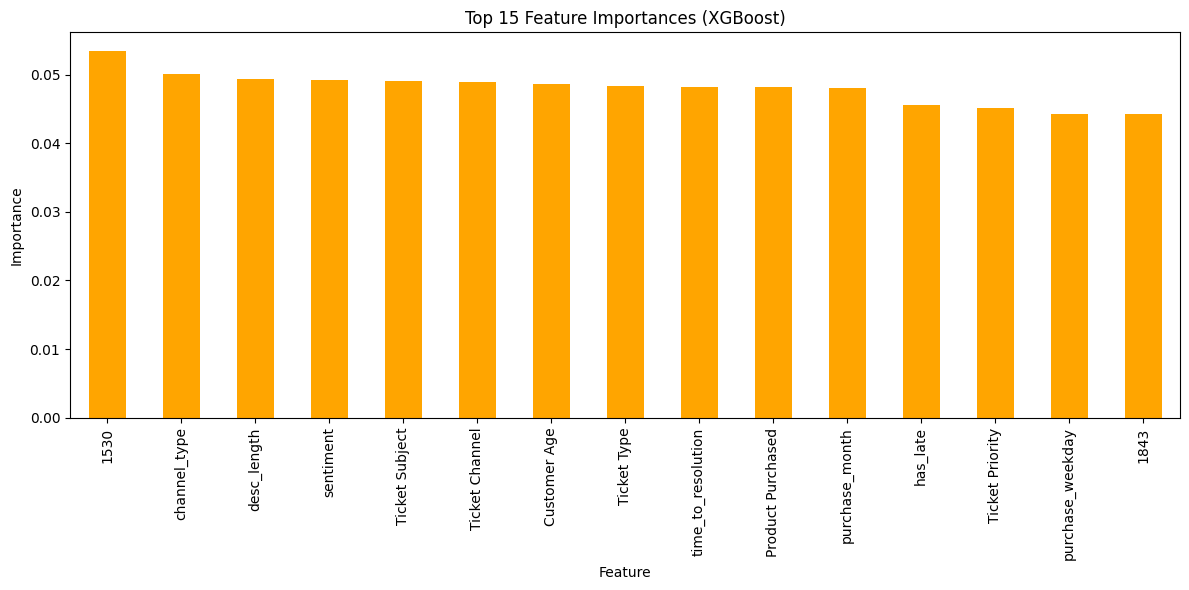

In [55]:
importances_xgb = xgb.feature_importances_
feat_imp_xgb = pd.Series(importances_xgb, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,6))
feat_imp_xgb.head(15).plot(kind='bar', color='orange')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

**3. Accuracy comparison table**

In [56]:
model_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [0.218, 0.209]
})
print(model_results)

           Model  Accuracy
0  Random Forest     0.218
1        XGBoost     0.209


**4. Error distribution visualization** 

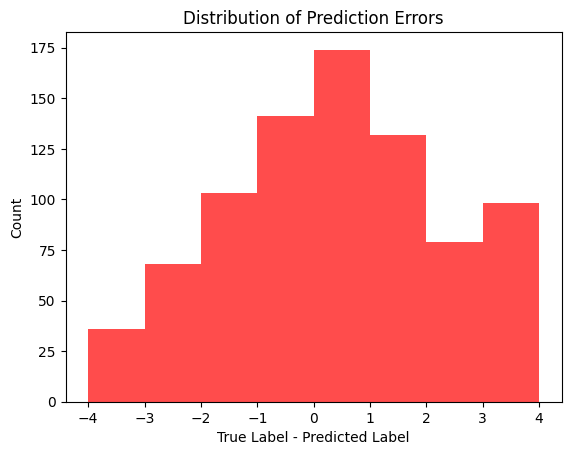

In [57]:
errors = y_test - y_pred
plt.hist(errors, bins=np.arange(-4,5), color='red', alpha=0.7)
plt.title("Distribution of Prediction Errors")
plt.xlabel("True Label - Predicted Label")
plt.ylabel("Count")
plt.show()


To enhance interpretability, I present the confusion matrix and feature importance barplots, clearly showing model strengths and the predictors most relevant to customer satisfaction. The accuracy table allows direct model comparison; the error distribution histogram pinpoints where further improvement is needed.